# Problem 1: Calculate PageRank

In [1]:
import numpy as np
alpha = 0.1
H_1 = np.matrix([[0, 0.5, 0.5],[0, 0, 1],[1, 0, 0]])
n = len(H_1)

# Replace zero rows with [1/n, ..., 1/n] to generate S matrix
S_1 = H_1.copy()
for idx in np.where(~H_1.any(axis=1))[0]:
    S_1[idx] = np.array([1/n]*n)

G = alpha*S_1 + (1-alpha)/n * np.ones((n,n))
print("Input Google Matrix: \n",G)

pi_0 = np.matrix([1/n]*n).T

print('Iteration starts ...')
tolerance = 1.0e-6
max_iter = 100
for k in range(max_iter):
    print('k =',k)
    if k == 0:
        input_pi = pi_0
    else:
        input_pi = new_pi
    new_pi = np.dot(input_pi.T,G).T

    # check convergence, l1 norm 
    diff = new_pi - input_pi
    err = 0
    for ele in diff:
        err+=abs(ele)

    if err < tolerance: 
        print(' Iteration Ends ...')
        print(" Final PageRanks are: \n",new_pi)
        break

Input Google Matrix: 
 [[0.3  0.35 0.35]
 [0.3  0.3  0.4 ]
 [0.4  0.3  0.3 ]]
Iteration starts ...
k = 0
k = 1
k = 2
k = 3
k = 4
 Iteration Ends ...
 Final PageRanks are: 
 [[0.33484167]
 [0.31674208]
 [0.34841625]]


##### Wrap into a function:

In [2]:
import time
import numpy as np
def MyPageRank_Calculator(H, alpha = 0.85, tol = 1.0e-6, max_iter = 100):
    '''
    Args
    -----------
    H: np.matrix
        n by n matrix indicating webpage connnections
    alpha: float between [0,1]
        Damping parameter for PageRank, default=0.85
    tolerance: float
        Iteration tolerance, default=1.0e-6
    max_iter: positive int
        maximum number of iterations accepted, default=100
    
    Returns
    -----------
    dic: dictionary
        Final results for PageRank scores
        
    '''
    n = len(H) # number of web nodes
    
    if not isinstance(H, np.matrix):
        raise TypeError('Input H should be in a np.matrix.')
    
    print('---Given H, n =',n,', alpha =',alpha,'-------------')
    print('Iterating starts ...')
    t0 = time.process_time()
    
    # Replace zero rows (dangling nodes) 
    # with [1/n, ..., 1/n] to generate S matrix
    dangling_nodes = np.where(~H.any(axis=1))[0]
    S = H.copy()
    for idx in dangling_nodes:
        S[idx] = np.array([1/n]*n)
    
    # Calculate Adjusted Google Matrix:
    G = alpha*S + (1-alpha)/n * np.ones((n,n))
    
    # initial pi vector for power method
    pi_0 = np.matrix([1/n]*n).T

    for k in range(max_iter):
        ## print('k =',k)
        if k == 0:
            input_pi = pi_0
        else:
            input_pi = new_pi
        new_pi = np.dot(input_pi.T,G).T

        # check convergence, l1 norm 
        diff = new_pi - input_pi
        err = 0
        for ele in diff:
            err+=abs(ele)
        if err < tolerance: 
            print('Iteration Ends at k =',k)
            print('Iterating time used:', time.process_time()-t0, 'seconds.')
            print('-------------------')
            dic = {}
            for idx, r in enumerate(new_pi):
                dic[idx] = r.item((0, 0))
            return dic
    raise RuntimeError('PageRank: power iteration failed to converge '
                    'in %d iterations. Please increase max_iter.' % max_iter)

# Example:
alpha = 0.1
H = np.matrix([[0, 0.5, 0.5],[0, 0, 1],[1, 0, 0]])
max_iter = 5
MyPageRank_Calculator(H = H, alpha = alpha, tol = tolerance, max_iter = max_iter)

---Given H, n = 3 , alpha = 0.1 -------------
Iterating starts ...
Iteration Ends at k = 4
Iterating time used: 0.0 seconds.
-------------------


{0: 0.33484166666666665, 1: 0.3167420833333333, 2: 0.34841625}

# 2. Empirical Investigation of the Convergence of Google PageRank:
In class we discussed the convergence of the power method used in Google Page Rank,
i.e.
$$ π′_{k+1} = π′_{k}\mathbf{G}$$
where $G$ depends on $α$ and $0 < α ≤ 1$. In this assignment you will study the convergence
of this iteration through simulations.

## (a) Implement a function that generates a random graph-transition matrix $H$ for a graph of $10,000$ nodes. See the suggestion below.

**Suggestion**: Instead of crawling the web to produce the $H$ matrix, one can construct a (random) synthetic version as follows: 
* For each row $i$ in $H$ draw a random number $π_i$ from a lognormal distribution. 
    - Suggestion: Provide your assumptions along with a motivation for why you chose certain parameter values. 
* Then rescale all {$π_i$} so that the maximum is about 20%. 
    - the matrix H is very sparse in practice, so we use 20% as the highest probability
* Given $π_i ∈ [0, 0.2]$ select with probability $π_i$ the non-zero indices of the $i^{th}$ row. 
* You now have a random graph distribution where the popularity of each node is approximately lognormal. 
* We leave the specific assumptions/details to you to work out.



In [3]:
import time
import numpy as np
np.random.seed(123)
def H_simulator(n: int):
    '''
    Randomly simulate a nxn stochastic matrix H that represents the connnection among webpages.
    A random graph distribution where the popularity of each node is approximately lognormal.
    
    Args
    ----------
    n: int
        number of webpage nodes
        
    Returns
    ---------
    H: np.matrix
        
    '''
    print('--- Given n =',n,'--------------')
    print('Simulating for a random H ...')
    t00 = time.process_time()
    
    # for each of n rows (for each node), draw a pi_i from lognormal distribution
    raw_values = np.random.lognormal(0, 1, n)

    # rescale s.t. the max = 0.2
    old_range = max(raw_values) - min(raw_values)
    new_range = 0.2
    new_values = [((pi - min(raw_values))*new_range)/old_range + 0 for pi in raw_values]
    
    # given pi_i used as probability, decide the number of nonzeros for each row, round to integer
    numbers_of_nonzeros_for_each_row = []
    for prob in new_values:
        numbers_of_nonzeros_for_each_row.append(int(round(n*prob)))
    
    # Randomly decided which entries to be the non-zero entries, store indices for each row
    # Nonzero entries should be the value of 1/(number of nonzero entries for each row)
    all_nonzero_indices = []
    target_entry = []
    for num in numbers_of_nonzeros_for_each_row:
        non_zero_indices_for_row_one = np.random.choice(n-1, size=num, replace=False)
        denom = len(non_zero_indices_for_row_one)
        if denom == 0:
            target_entry.append(0)
        else:
            target_entry.append(1/denom)
        all_nonzero_indices.append(non_zero_indices_for_row_one)

    # construct H:
    H = []
    for idxs, entry in zip(all_nonzero_indices,target_entry):
        row = [0]*n
        for idx in idxs:
            # print(idx)
            row[idx] = entry
        H.append(row)
    print('Simulating Ends.')
    print('Time used:', time.process_time()-t00, 'seconds.')
    print('-------------------')
    return np.matrix(H)

##### Setup before interating:

In [4]:
n = 10000
simulated_H = H_simulator(n)
dangling_nodes = np.where(~simulated_H.any(axis=1))[0]
print('dangling_nodes: \n',dangling_nodes)

--- Given n = 10000 --------------
Simulating for a random H ...
Simulating Ends.
Time used: 24.203125 seconds.
-------------------
dangling_nodes: 
 [1638 1694 6741 6856 7533 8767]


##### Iterating method 1:

In [5]:
mypageranks = MyPageRank_Calculator(H = simulated_H)
print('Some example result:')
iterator = iter(mypageranks.items())
for i in range(3):
    print(next(iterator))
print('...')

---Given H, n = 10000 , alpha = 0.85 -------------
Iterating starts ...
Iteration Ends at k = 8
Iterating time used: 16.3125 seconds.
-------------------
Some example result:
(0, 9.502509237316777e-05)
(1, 8.2873527102901e-05)
(2, 0.00012200614233510237)
...


In [6]:
# make sure that everytime I ran the iteration, the original H stays there
# with correct dangling_nodes:
dangling_nodes = np.where(~simulated_H.any(axis=1))[0]
print('dangling_nodes: \n',dangling_nodes)

dangling_nodes: 
 [1638 1694 6741 6856 7533 8767]


## (b) Implement a function that evaluates the matrix/vector multiplication $x′G$ efficiently.

While $G$ is a dense matrix, we can still perform matrix vector multiplication much more efficiently than $O(n^2)$:

\begin{align}
π′_{k+1} & = π′_{k}\mathbf{G} \\
& = απ′_{k}\mathbf{S} + \frac{(1 − α)}{n}π′_{k}\mathbf{e}\mathbf{e}′ \\
& = απ′_{k}(\mathbf{H} + \frac{1}{n}\mathbf{a}\mathbf{e}′) + \frac{(1 − α)}{n}π′_{k}\mathbf{e}\mathbf{e}′ \\
& = απ′_{k}\mathbf{H} + π′_{k}(α\mathbf{a} + (1 − α)\mathbf{e})\frac{1}{n}\mathbf{e}′ 
\end{align}

Where $$S := H + \frac{1}{n}\mathbf{a}\mathbf{e}′$$ and the vector $\mathbf{a}$ is defined as
$$
\mathbf{a}_i= 
\begin{cases}
    1,& \text{if row i is a zero row (i.e. dangling node)} \\
    0,& \text{otherwise}
\end{cases}
$$

and $$\mathbf{e} := (1, . . . , 1)′$$.

**This matrix multiplication is $O(n)$**

Note: The Google matrix is a very sparse matrix. As reported by Langville and Meyer (2011) the average number of a page’s outlinks is about $10$. This means that the complexity of computing the matrix vector multiplication of $Hx$ is about $O(10n) = O(n)$ in comparison to $O(n^2)$ for a dense matrix.

In [7]:
def MyPageRank_Calculator_modified(H, alpha = 0.85, tol = 1.0e-6, max_iter = 100):
    # input H 
    H_use = H.copy()
    n = len(H_use)
    
    print('--- Given H, n =',n,', alpha =',alpha,'-------------')
    print('Iterating starts ...')
    t0 = time.process_time()
    
    # construct e
    e = np.matrix([1]*n).T

    # construct vector a
    # dangling index if zero row in H
    dangling_nodes = np.where(~H_use.any(axis=1))[0]
    
    a = []
    for row in range(n):
        if row in dangling_nodes:
            a.append(1)
        else:
            a.append(0)
    a = np.matrix(a).T
   
    # initial pi vector for power method
    pi_0 = np.matrix([1/n]*n).T
    
    for k in range(max_iter):
        ## print('k =',k)
        if k == 0:
            input_pi = pi_0
        else:
            input_pi = new_pi

        c1  = alpha * np.dot(input_pi.T,H_use)
        c2 = alpha * a + (1-alpha)*e
        c3 = np.dot(input_pi.T, c2)
        c4 = np.dot(c3, 1/n * e.T )
        new_pi = (c1 + c4).T
        
        # check convergence, l1 norm 
        diff = new_pi - input_pi
        err = 0
        for ele in diff:
            err+=abs(ele)
        if err < tolerance: 
            print('Iteration Modified Ends at k =',k)
            print('Iterating time used:', time.process_time()-t0, 'seconds.')
            print('-------------------')
            dic = {}
            for idx, r in enumerate(new_pi):
                dic[idx] = r.item((0, 0))
            return dic
    raise RuntimeError('PageRank: power iteration failed to converge '
                    'in %d iterations. Please increase max_iter.' % max_iter)

##### Iterating method 2:

In [8]:
mypageranks_2 = MyPageRank_Calculator_modified(H = simulated_H)
print('Some example result:')
iterator_2 = iter(mypageranks_2.items())
for i in range(3):
    print(next(iterator_2))
print('...')

--- Given H, n = 10000 , alpha = 0.85 -------------
Iterating starts ...
Iteration Modified Ends at k = 8
Iterating time used: 5.265625 seconds.
-------------------
Some example result:
(0, 9.502509237316789e-05)
(1, 8.28735271029012e-05)
(2, 0.00012200614233510255)
...


## (c) For all $α ∈ np.linspace(1e-4,0.1, 10)$ compute the first two eigenvalues of $G(α)$. Create a plot of each eigenvalue as a function of $α$.

In [9]:
def G_generator(alpha, H):
    n = len(H)
    # Replace zero rows with [1/n, ..., 1/n] to generate S matrix
    dangling_nodes_indices = np.where(~H.any(axis=1))[0]
    
    H_use = H.copy()
    S = H_use
    for idx in dangling_nodes_indices:
        S[idx] = np.array([1/n]*n)
        
    # Calculate Adjusted Google Matrix:
    G = alpha*S + (1-alpha)/n * np.ones((n,n))
    return G

##### Calculate eigenvalues of G:
To achieve a high speed of eigenvalue calculation on a really sparse matrix, I am using two potential  eigenvalue solvers called ``eigsh`` and ``eigs``.

* **The method ``eigs`` used for general sparse matrix including non-symmetric ones, but it is much slower than ``eigsh``.**

* **The method ``eigsh``, however, does not check the input G for being Hermitian; it just follows a process assuming it is. Therefore, we cannot legally use it. Only for a higer speed, we can pretend to assume the $\mathbf{G}$ is being a Hermitian matrix that is equal to its own conjugate transpose, i.e. ``G = G.H``.**

**In the cell below, I called ``eigs``. There is another version using ``eigsh`` implemented though.**

Forum: 

* Using a built in eigenvalue solver is fine
* Try to find a computational approach that **does not form the full dense matrix** when doing this though!
* In other words, try to use a solver that leverages the $O(n)$ matrix-vector multiplication you develop in (b). 
* Some possibilities include:
    - inverse iteration combined with Rayleigh quotient iteration. **Cannot apply here since we are not dealing with symmetric matrix.**
    - Arnoldi iteration combined with the Rayleigh-Ritz method. **This is a much more applicable approach.** But I need to do more reseaches on it so that I can implement it from scratch:)

In [10]:
first_es = []
second_es = []
ratio = []

from scipy.sparse.linalg import eigsh, eigs

dangling_nodes = np.where(~simulated_H.any(axis=1))[0]
print('dangling_nodes: \n',dangling_nodes)

alphas = np.linspace(1e-4, 0.1, 10)
i = 1
for alpha in alphas:
    print('----------')
    print(i,': alpha =', round(alpha, 5), 'starts ...')
    simulated_G = G_generator(alpha, simulated_H)
    
    '''
    vals = eigsh(simulated_G, k=2, which='LM', return_eigenvectors=False)
    print('first eigenvalue: ', abs(vals[1]))
    first_es.append(abs(vals[1]))
    print('|scond eigenvalue|: ',abs(vals[0]))
    second_es.append(abs(vals[0]))
    ratio.append(abs(vals[0])/abs(vals[1]))
    
    '''
    vals = eigs(simulated_G, k=2, which='LM', return_eigenvectors=False)
    print('first eigenvalue: ', abs(vals[0]))
    first_es.append(abs(vals[0]))
    print('|scond eigenvalue|: ',abs(vals[1]))
    second_es.append(abs(vals[1]))
    ratio.append(abs(vals[1])/abs(vals[0]))
          
    i+=1

dangling_nodes: 
 [1638 1694 6741 6856 7533 8767]
----------
1 : alpha = 0.0001 starts ...
first eigenvalue:  1.0000000000000002
|scond eigenvalue|:  2.333597440196664e-05
----------
2 : alpha = 0.0112 starts ...
first eigenvalue:  1.0000000000000004
|scond eigenvalue|:  0.002613629133020251
----------
3 : alpha = 0.0223 starts ...
first eigenvalue:  0.9999999999999996
|scond eigenvalue|:  0.005203922291638563
----------
4 : alpha = 0.0334 starts ...
first eigenvalue:  0.9999999999999994
|scond eigenvalue|:  0.0077898969566638325
----------
5 : alpha = 0.0445 starts ...
first eigenvalue:  1.0000000000000007
|scond eigenvalue|:  0.010384508608875093
----------
6 : alpha = 0.0556 starts ...
first eigenvalue:  1.0000000000000004
|scond eigenvalue|:  0.012974801767493466
----------
7 : alpha = 0.0667 starts ...
first eigenvalue:  1.0000000000000004
|scond eigenvalue|:  0.015556470868547136
----------
8 : alpha = 0.0778 starts ...
first eigenvalue:  0.9999999999999989
|scond eigenvalue|:  0

Ploting first two eigenvalues vs alphas ...


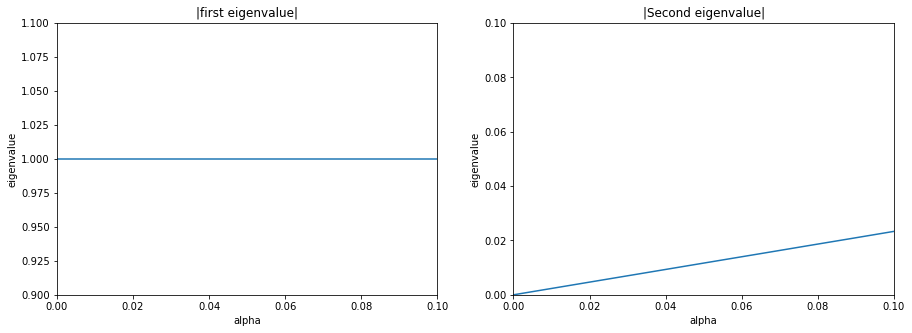

In [11]:
print('Ploting first two eigenvalues vs alphas ...')
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, first_es)
plt.axis([0, 0.10, 0.9, 1.1])
plt.title('|first eigenvalue|')
plt.ylabel('eigenvalue')
plt.xlabel('alpha')

plt.subplot(1, 2, 2)
plt.plot(alphas, second_es)
plt.axis([0, 0.10, 0, 0.10])
plt.title('|Second eigenvalue|')
plt.ylabel('eigenvalue')
plt.xlabel('alpha')

plt.show()

Ploting the ratio of first two eigenvalues vs alphas ...


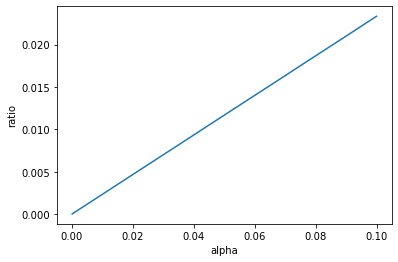

In [12]:
print('Ploting the ratio of first two eigenvalues vs alphas ...')
plt.plot(alphas, ratio)
plt.ylabel('ratio')
plt.xlabel('alpha')
plt.show()

## (d) Using simulations determine how the convergence of $a_k :=  ∥π_k − π_{k−1}∥$ depends on $α$. Are your observations consistent with the theoretical results from class? Discuss.

In class:

How many iterations does the iteration take until it has converged to a usable accuracy? 
* Brin and Page reported in their 1998 papers, and others have confirmed, that only **50 ~ 100** power iterations are needed before the iterates have converged, giving a satisfactory approximation to the exact PageRank vector.

Why are only about **50** iterations necessary for convergence?
* Langville and Meyer (2011) discuss this in quite some detail. 
* Briefly, the asymptotic rate of convergence of the iterative scheme is determined by the ratio $|\frac{λ_2}{λ_1}|$, where $λ_1$ and $λ_2$ are the largest and second largest eigenvalues of matrix used in the iteration. 
* For $\mathbf{G}$, $λ_1 = 1$ and $|λ_2| < 1$. Langville and Meyer (2011, Theorem 4.7.1, p. 46) argue that in most cases $|λ_2| ≈ α$. In their papers, Brin and Page use $α = 0.85$. 
* Note that $α^{50} = 0.8550 ≈ 0.000296$ which implies that with $50$ iterations we can expect roughly 2 ~ 3 places of accuracy in the approximate PageRank vector.

##### The speed of convergence depends on how fast $(\frac{\lambda_2}{\lambda_1})^m ≈ (\frac{\alpha}{1})^m = \alpha^m→ 0$:

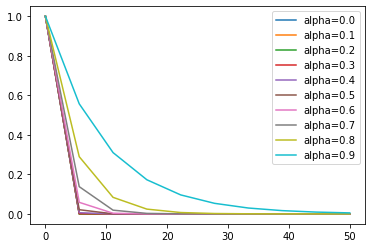

In [13]:
alphas = np.linspace(1e-4, 0.9, 10)
xs = np.linspace(0, 50, 10)
for al in alphas:
    ys = []
    for m in xs:
        ys.append(al**m)
    plt.plot(xs, ys, label='alpha='+str(round(al,3)))
plt.legend()
plt.show()

Obviously, the smaller $\alpha$ is, the faster the speed of convergence is.

#### From my simulation, I found the second largest eigenvalue of matrix $\mathbf{G}$ is not approximately equal to $\alpha$, which is not consistent with the theoretical result from class. However, it is true that the converge speed (i.e. the asymptotic rate of convergence, or $|\frac{λ_2}{λ_1}| ≈ \frac{\alpha}{1} = \alpha$ ) depends on our choice of $\alpha$.